- Minecraft Version 1.21.5
- Seed: "vcpi"
- Gamerules: "doDaylightCycle=false" "doWeatherCycle=false" "doMobSpawning=false"
- Commands. /time set day
- render distance: 12

In [3]:
import os
import time

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

from src.dataset import PairedImageDataset
from src.plot_utils import show_image_pairs, show_combined_results
from src.models import GeneratorUNet, PatchDiscriminator, weights_init_normal
from src.checkpoint_utils import save_checkpoint, load_checkpoint
from src.losses import L2Loss, SSIMLoss


cuda = torch.cuda.is_available()

device = torch.device("cuda" if cuda else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

full_dataset = PairedImageDataset("generator_bot/screenshots", transforms=transform)

dataset_size = len(full_dataset)
test_size = int(0.1 * dataset_size)
train_size = dataset_size - test_size

print(f"Total dataset size: {dataset_size}")
print(f"Train size: {train_size}")
print(f"Test size: {test_size}")

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

BATCH_SIZE = 4

train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=8)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=8)

print(f"Train batches: {len(train_dl)}")
print(f"Test batches: {len(test_dl)}")

Total dataset size: 3600
Train size: 3240
Test size: 360
Train batches: 810
Test batches: 90


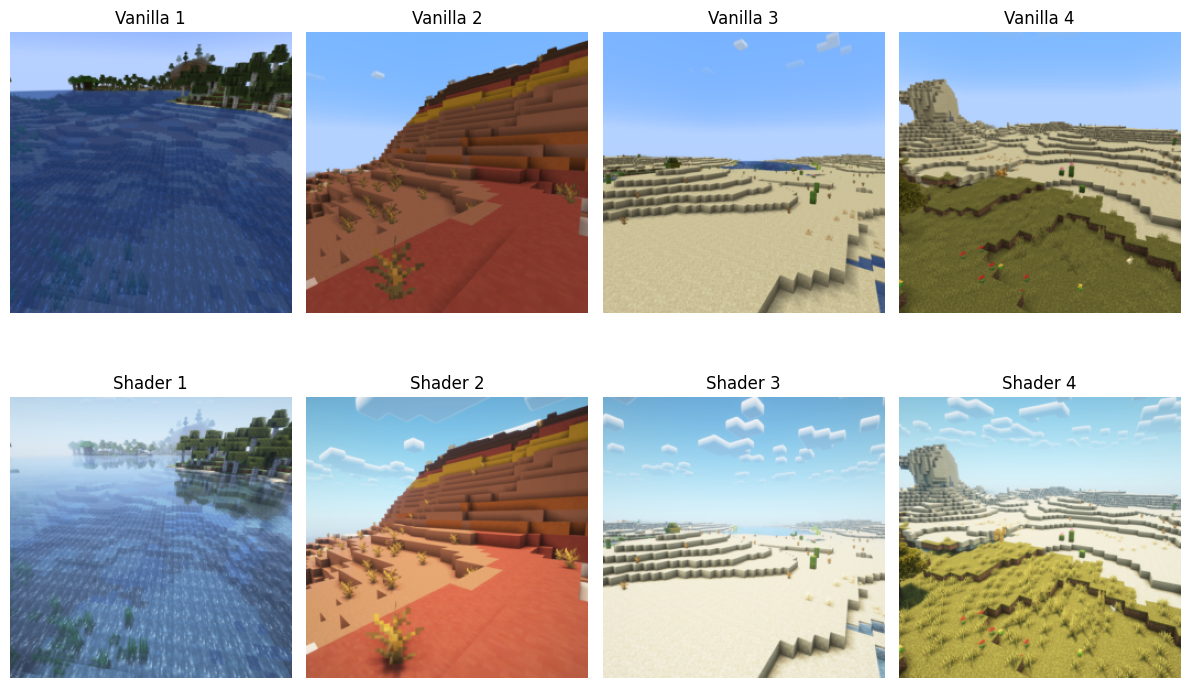

In [5]:
show_image_pairs(train_dl, num_pairs=4)

In [6]:
def train_epoch(dataloader, G, D, g_opt, d_opt, gan_crit, recon_crit, lambda_recon=100):
    G.train()
    D.train()

    total_discriminator_loss = 0
    total_generator_loss = 0

    num_batches = 0

    loop = tqdm(dataloader, leave=True, unit_scale=BATCH_SIZE, unit="pairs")

    for batch in loop:
        x = batch["vanilla"].to(device, non_blocking=True)
        y = batch["shader"].to(device, non_blocking=True)

        valid = torch.ones((x.size(0), 1, 16, 16), device=device)
        fake = torch.zeros_like(valid)

        # ---- Discriminator ----
        d_opt.zero_grad()
        # Real
        real_pred = D(x, y)
        d_real_loss = gan_crit(real_pred, valid)
        # Fake
        y_fake = G(x)
        fake_pred = D(x, y_fake.detach())
        d_fake_loss = gan_crit(fake_pred, fake)
        d_loss = (d_real_loss + d_fake_loss) * 0.5
        d_loss.backward()
        d_opt.step()

        # ---- Generator ----
        g_opt.zero_grad()
        # GAN loss
        fake_pred = D(x, y_fake)
        g_gan = gan_crit(fake_pred, valid)
        # Reconstruction loss
        g_recon = recon_crit(y_fake, y) * lambda_recon
        g_loss = g_gan + g_recon
        g_loss.backward()
        g_opt.step()

        total_discriminator_loss += d_loss.item()
        total_generator_loss += g_loss.item()
        num_batches += 1

        loop.set_postfix(d_loss=total_discriminator_loss / num_batches, g_loss=total_generator_loss / num_batches, num_batches=num_batches)

    return total_discriminator_loss / num_batches, total_generator_loss / num_batches


def create_model(device):
    """Create and initialize a new model"""
    G = GeneratorUNet().to(device)
    D = PatchDiscriminator().to(device)

    G.apply(weights_init_normal)
    D.apply(weights_init_normal)

    g_opt = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
    d_opt = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

    return G, D, g_opt, d_opt


# Checkpoint configuration
CHECKPOINT_FREQUENCY = 20  # Save checkpoint every N epochs
CHECKPOINT_BASE_DIR = "E:/minecraft-gan-checkpoints"  # Change this to your desired disk/path


def train_with_loss_functions(gan_crit, recon_crit, lambda_recon, config_name, epochs=5, load_epoch=None):
    """Train a model with specific loss functions"""
    print(f"\n{'=' * 60}")
    print(f"Training with {config_name}")
    print(f"{'=' * 60}")

    # Create fresh model
    G, D, g_opt, d_opt = create_model(device)
    
    # Load checkpoint if specified
    start_epoch = 0
    if load_epoch is not None:
        checkpoint_dir = os.path.join(CHECKPOINT_BASE_DIR, config_name)
        start_epoch = load_checkpoint(load_epoch, G, D, g_opt, d_opt, device, checkpoint_dir)
        print(f"Resumed training from epoch {start_epoch}")

    # Train for specified epochs
    for epoch in range(start_epoch, epochs):
        print(f"\nEpoch {epoch + 1}/{epochs} - {config_name}")
        print("-" * 50)

        d_loss, g_loss = train_epoch(train_dl, G, D, g_opt, d_opt, gan_crit, recon_crit, lambda_recon)
        print(f"Train - D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

        # Save checkpoint every CHECKPOINT_FREQUENCY epochs or on final epoch
        if (epoch + 1) % CHECKPOINT_FREQUENCY == 0 or epoch == epochs - 1:
            checkpoint_dir = os.path.join(CHECKPOINT_BASE_DIR, config_name)
            save_checkpoint(epoch, G, D, g_opt, d_opt, checkpoint_dir)

    return G

In [7]:
EPOCHS = 300

LOSS_CONFIGS = {
    "l1_bce": {"gan_loss": nn.BCEWithLogitsLoss(), "recon_loss": nn.L1Loss(), "lambda_recon": 100},
    "l2_bce": {"gan_loss": nn.BCEWithLogitsLoss(), "recon_loss": L2Loss(), "lambda_recon": 100},
    "ssim_bce": {
        "gan_loss": nn.BCEWithLogitsLoss(),
        "recon_loss": SSIMLoss(device=device, data_range=(-0.5, 0.5)),
        "lambda_recon": 30,
    },
}

CHECKPOINT_LOAD_MAP = {
    "l1_bce": 300,
    "l2_bce": 300,
    "ssim_bce": 300,
}

trained_models = {}
start_time = time.time()

for config_name in LOSS_CONFIGS.keys():
    config_start_time = time.time()

    config = LOSS_CONFIGS[config_name]
    gan_crit = config["gan_loss"]
    recon_crit = config["recon_loss"]
    lambda_recon = config["lambda_recon"]

    load_epoch = CHECKPOINT_LOAD_MAP.get(config_name, None)

    trained_model = train_with_loss_functions(gan_crit, recon_crit, lambda_recon, config_name, epochs=EPOCHS, load_epoch=load_epoch)
    trained_models[config_name] = trained_model

    config_time = time.time() - config_start_time
    print(f"Completed {config_name} in {config_time:.1f}s")

total_time = time.time() - start_time
print(f"\nAll training completed in {total_time:.1f}s")
print(f"Trained {len(trained_models)} models with different loss configurations")


Training with l1_bce
Loading checkpoint: E:/minecraft-gan-checkpoints\l1_bce\checkpoint_epoch_300.pth
Resumed training from epoch 300
Completed l1_bce in 4.6s

Training with l2_bce
Loading checkpoint: E:/minecraft-gan-checkpoints\l2_bce\checkpoint_epoch_300.pth
Resumed training from epoch 300
Completed l2_bce in 4.4s

Training with ssim_bce
Loading checkpoint: E:/minecraft-gan-checkpoints\ssim_bce\checkpoint_epoch_300.pth
Resumed training from epoch 300
Completed ssim_bce in 0.4s

All training completed in 9.3s
Trained 3 models with different loss configurations


Comparing results from all loss configurations:


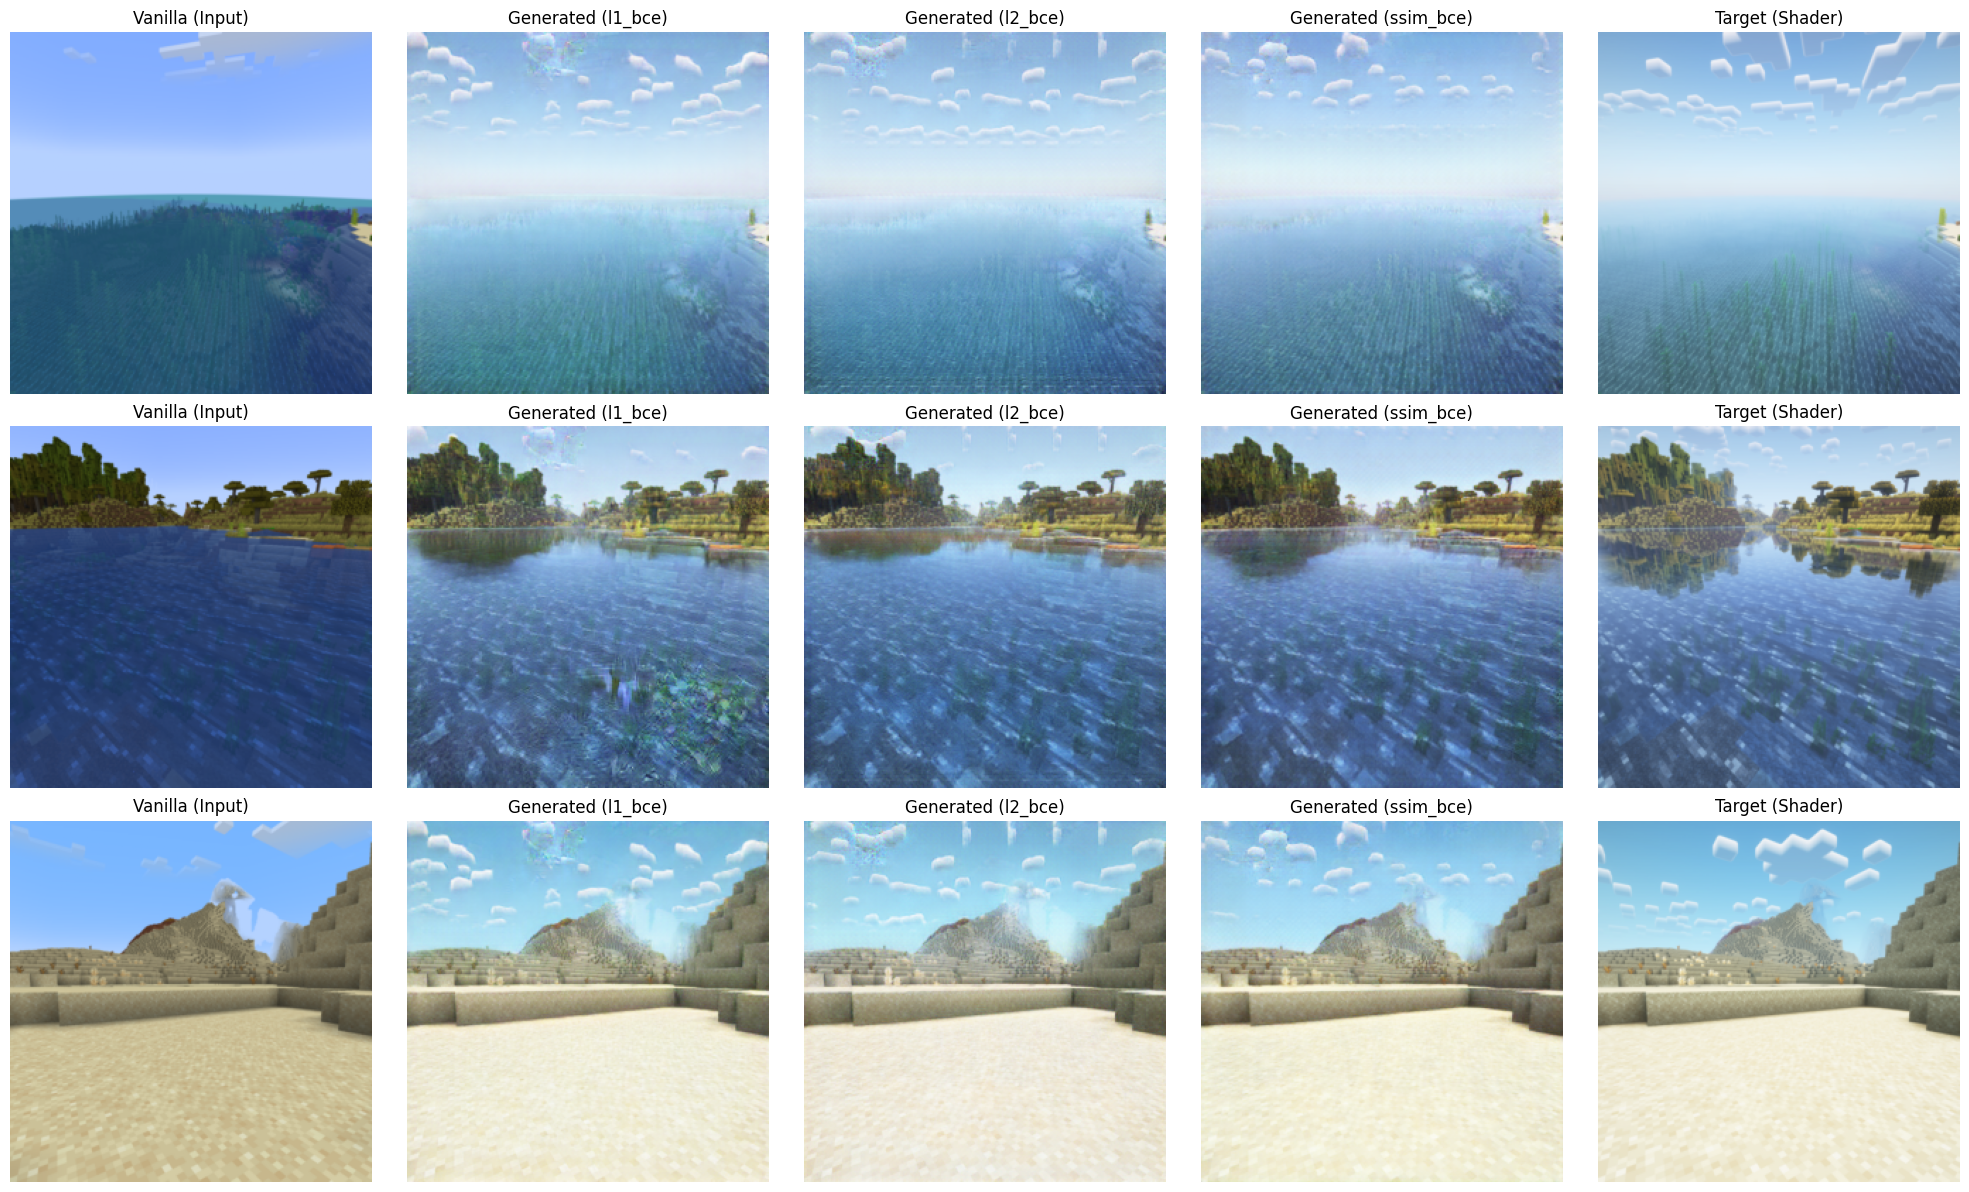

In [8]:
# Show combined results from all trained models
show_combined_results(trained_models, test_dl, device, num_samples=3)